In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torchvision import transforms, datasets
#from torchsummary import summary
from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

get the MNIST data

In [3]:
train_data = datasets.MNIST(
    root="./",
    train=True,
#    download=True,
    transform=transforms.ToTensor()
)

# Test data
test_data = datasets.MNIST(
    root="./",
    train=False,
#    download=True, #already downloaded with train data above
    transform=transforms.ToTensor()
)

The first time you run the above, use download=True to download data to MNIST/ directory under whatever is your preferred root.<br>
it'll report something like this:

    Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
    Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./MNIST/raw/train-images-idx3-ubyte.gz
    9912422/9912422 [00:00<00:00, 30462067.68it/s]
    Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

    Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
    Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./MNIST/raw/train-labels-idx1-ubyte.gz
    28881/28881 [00:00<00:00, 1054729.59it/s]
    Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

    Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
    Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./MNIST/raw/t10k-images-idx3-ubyte.gz
    1648877/1648877 [00:00<00:00, 22395368.65it/s]
    Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

    Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
    Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./MNIST/raw/t10k-labels-idx1-ubyte.gz
    4542/4542 [00:00<00:00, 168902.64it/s]
    Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

The data consists of 28x28 images of digits.<br>
Note that the 60000 training data and labels are called train_data.data.shape, train_data.targets,<br>
and similarly the 10000 test data and labels are called test_data.data.shape, test_data.targets

In [4]:
train_data.data.shape, train_data.targets.shape, test_data.data.shape, test_data.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

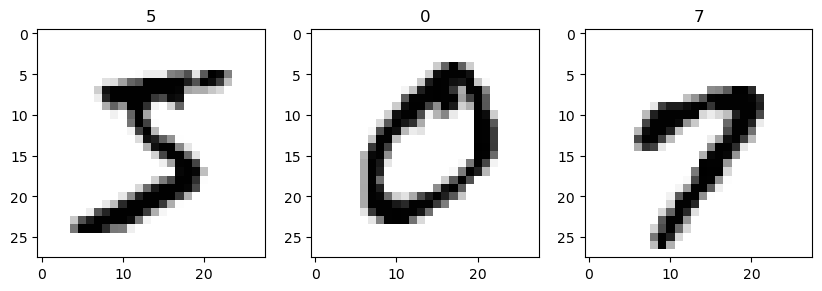

In [5]:
#28x28 samples
plt.figure(figsize=(10,6))
for i,j in enumerate([0,1,15]):
    plt.subplot(1,3,i+1)
    plt.imshow(train_data.data[j], cmap='binary')
    plt.title(train_data.targets[j].item())

# data loader

In [6]:
# Dataloaders
batch_size = 64 #32 #128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

These serve out the data in batches of size `batch_size`:

In [7]:
for i,(X,y) in enumerate(train_loader):
    if i<5: print (i,X.shape,y.shape)
print('...', i,X.shape,y.shape)

0 torch.Size([64, 1, 28, 28]) torch.Size([64])
1 torch.Size([64, 1, 28, 28]) torch.Size([64])
2 torch.Size([64, 1, 28, 28]) torch.Size([64])
3 torch.Size([64, 1, 28, 28]) torch.Size([64])
4 torch.Size([64, 1, 28, 28]) torch.Size([64])
... 937 torch.Size([32, 1, 28, 28]) torch.Size([32])


# I. 92.6% MNIST model
First recall how logistic regression does ("no hidden layer network")

In [8]:
%%time
from sklearn.linear_model import LogisticRegression

logreg_multi = LogisticRegression(max_iter=10, multi_class='multinomial')
logreg_multi.fit(train_data.data.flatten(1,-1), train_data.targets)
print('training score', logreg_multi.score(train_data.data.flatten(1,-1), train_data.targets))
print('test score', logreg_multi.score(test_data.data.flatten(1,-1), test_data.targets))

training score 0.9392833333333334
test score 0.9256
CPU times: user 4min 22s, sys: 1.64 s, total: 4min 24s
Wall time: 1min 6s


# II. 98.1% MNIST model

In [9]:
model2 = nn.Sequential(
  nn.Flatten(),

  nn.Linear(28*28,128),   #128 node layer, fully connected
  nn.ReLU(), # or .Tanh(), or .Sigmoid()
  nn.Dropout(.2), #improves training
    
  nn.Linear(128,10),   # connects to 10 node output layer
)

learning_rate = 1e-3;
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
nn.Dropout?

In [10]:
inp = torch.tensor([1.0, 2.0, 3, 4, 5])

nn.Dropout(p=0.4)(inp)

tensor([0.0000, 3.3333, 5.0000, 0.0000, 0.0000])

In [11]:
model2

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
#not yet trained
model2(train_data.data[:10].float()).argmax(1), train_data.targets[:10]

(tensor([7, 0, 9, 1, 5, 0, 0, 0, 0, 5]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))

In [13]:
# high loss, ~10% test accuracy
y_pred = model2(train_data.data.float())
loss = loss_fn(y_pred, train_data.targets)
print(loss.item(),
      (model2(test_data.data.float()).argmax(1) == test_data.targets).sum().item() / len(test_data))

39.88449478149414 0.1083


In [14]:
epochs = 20  #about four seconds per epoch
scores2 = []

for t in range(epochs):
    print(f'Epoch {t+1}: ', end='')

    model2.train() #turns on dropout
    for batch,(x, y) in enumerate(train_loader):
        # Compute prediction and loss
        pred = model2(x)
        loss = loss_fn(pred, y)
 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model2.eval()  #turns off dropout
    train_score = (model2(train_data.data.float()).argmax(1) == train_data.targets).sum().item() / len(train_data)
    test_score = (model2(test_data.data.float()).argmax(1) == test_data.targets).sum().item() / len(test_data)
    print(f'loss={loss.item():.3f}, training_score={train_score:.1%}, test_score={test_score:.1%}')
    scores2.append((train_score, test_score))

Epoch 1: loss=0.083, training_score=94.7%, test_score=94.6%
Epoch 2: loss=0.258, training_score=96.5%, test_score=96.0%
Epoch 3: loss=0.125, training_score=97.4%, test_score=96.9%
Epoch 4: loss=0.036, training_score=97.8%, test_score=97.1%
Epoch 5: loss=0.087, training_score=98.3%, test_score=97.4%
Epoch 6: loss=0.225, training_score=98.4%, test_score=97.4%
Epoch 7: loss=0.049, training_score=98.7%, test_score=97.7%
Epoch 8: loss=0.040, training_score=99.0%, test_score=97.8%
Epoch 9: loss=0.067, training_score=99.1%, test_score=97.8%
Epoch 10: loss=0.042, training_score=99.2%, test_score=97.8%
Epoch 11: loss=0.043, training_score=99.3%, test_score=97.8%
Epoch 12: loss=0.029, training_score=99.4%, test_score=97.9%
Epoch 13: loss=0.002, training_score=99.4%, test_score=97.7%
Epoch 14: loss=0.065, training_score=99.5%, test_score=97.9%
Epoch 15: loss=0.063, training_score=99.5%, test_score=97.8%
Epoch 16: loss=0.006, training_score=99.7%, test_score=98.0%
Epoch 17: loss=0.018, training_sc

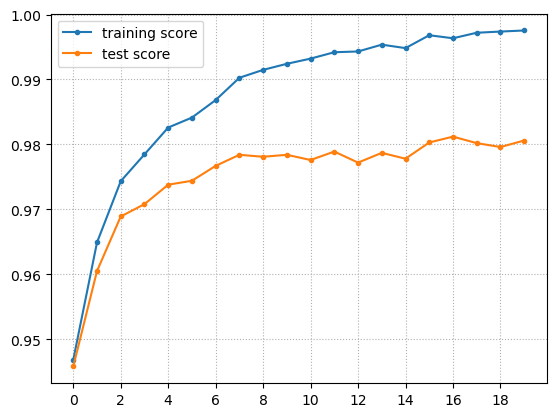

In [15]:
plt.plot(range(len(scores)), *np.array(scores).T, marker='.')
plt.xticks(range(0,len(scores),2))
plt.grid(ls=':')
plt.legend(['training score','test score']);

In [16]:
# Note that test items have different numbers per class
from collections import Counter
c = Counter([y.item() for y in y_test])
print([(i,c[i]) for i in range(10)])

[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


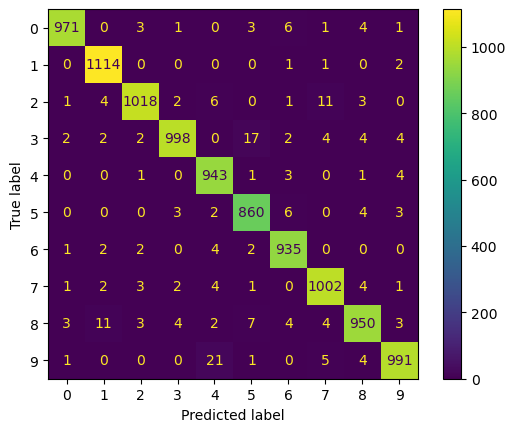

In [17]:
# confusion matrix for test items
y_pred = model2(test_data.data.float()).argmax(1)
ConfusionMatrixDisplay.from_predictions(y_pred, test_data.targets);

# III. 99.1% MNIST model
Now train a CNN:

In [18]:
model99 = nn.Sequential(
    
    nn.Conv2d(1, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    
    nn.Conv2d(32, 64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    
    nn.Flatten(),
#    nn.Dropout(0.5),### try without dropout
    
    nn.Linear(64*4*4, 10),
)

optimizer = torch.optim.Adam(model99.parameters(), 1e-3)

In [19]:
#find total number of parameters
for layer in model99.parameters():
    print(layer.shape, np.prod(layer.shape))
print('Total =', sum([np.prod(layer.shape) for layer in model99.parameters()]))

torch.Size([32, 1, 5, 5]) 800
torch.Size([32]) 32
torch.Size([64, 32, 5, 5]) 51200
torch.Size([64]) 64
torch.Size([10, 1024]) 10240
torch.Size([10]) 10
Total = 62346


In [20]:
# takes about 15sec per epoch
scores99 = []
for epoch in range(15):
    train_loss = []
    train_accuracy = []

    for i, (x, y) in enumerate(train_loader):
        # pass data through network
        pred = model99(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
        train_accuracy.append((pred.argmax(1) == y).sum().item() / len(pred))        
        
    test_loss = []
    test_accuracy = []
    for i, (x, y) in enumerate(test_loader):
        # pass data through network
        pred = model99(x)
        loss = loss_fn(pred, y)
        test_loss.append(loss.item())
        test_accuracy.append((pred.argmax(1) == y).sum().item() / len(pred))
        
    print(f'epoch: {epoch}, train loss: {np.mean(train_loss):.5f}, test loss: {np.mean(test_loss):.5f}, ' +\
          f'train_score: {np.mean(train_accuracy):.1%}, test_score: {np.mean(test_accuracy):.1%}')
    scores99.append((np.mean(train_loss),np.mean(test_loss),np.mean(train_accuracy),np.mean(test_accuracy)))

epoch: 0, train loss: 0.16481, test loss: 0.04862, train_score: 95.2%, test_score: 98.5%
epoch: 1, train loss: 0.05030, test loss: 0.03732, train_score: 98.4%, test_score: 98.9%
epoch: 2, train loss: 0.03390, test loss: 0.03143, train_score: 98.9%, test_score: 99.0%
epoch: 3, train loss: 0.02695, test loss: 0.02882, train_score: 99.1%, test_score: 99.0%
epoch: 4, train loss: 0.02101, test loss: 0.02802, train_score: 99.3%, test_score: 99.0%
epoch: 5, train loss: 0.01608, test loss: 0.02950, train_score: 99.5%, test_score: 99.1%
epoch: 6, train loss: 0.01358, test loss: 0.03220, train_score: 99.6%, test_score: 98.9%
epoch: 7, train loss: 0.01121, test loss: 0.03266, train_score: 99.7%, test_score: 99.0%
epoch: 8, train loss: 0.00856, test loss: 0.02904, train_score: 99.7%, test_score: 99.2%
epoch: 9, train loss: 0.00880, test loss: 0.02997, train_score: 99.7%, test_score: 99.2%
epoch: 10, train loss: 0.00591, test loss: 0.03705, train_score: 99.8%, test_score: 99.0%
epoch: 11, train los

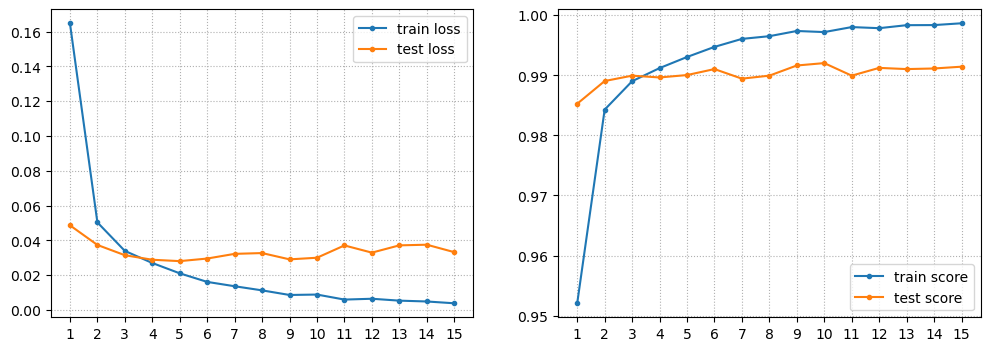

In [21]:
scores99 = np.array(scores99)
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(scores99.T[0], '.-', label='train loss')
plt.plot(scores99.T[1], '.-', label='test loss')
plt.xticks(range(15), range(1,16))
plt.legend()
plt.grid(ls=':');

plt.subplot(122)
plt.plot(scores99.T[2], '.-', label='train score')
plt.plot(scores99.T[3], '.-', label='test score')
plt.xticks(range(15), range(1,16))
plt.legend()
plt.grid(ls=':');

See a few that it had wrong

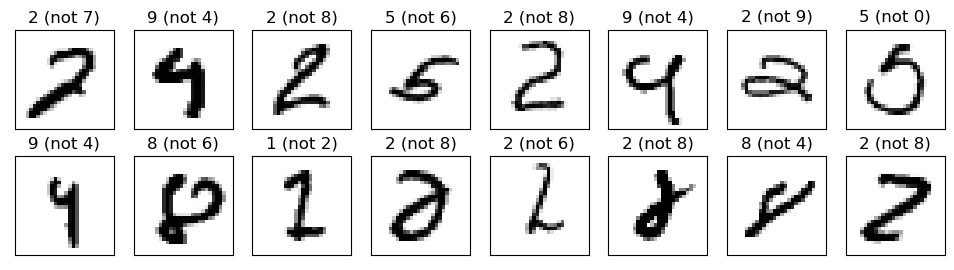

In [22]:
# training: 99.9% corresponds to about 50-100 wrong out of 60000 

wrong = np.where(model99(train_data.data[:,None].float()).argmax(1) != y_train)[0]
predicted = model99(train_data.data[wrong[:16],None].float()).argmax(1)

plt.figure(figsize=(12,3))
for k,i in enumerate(wrong[:16]):
    plt.subplot(2,8,k+1)
    plt.imshow(train_data.data[i], cmap='binary')
    plt.xticks([]), plt.yticks([])
    plt.title(f'{train_data.targets[i].item()} (not {predicted[k]})')

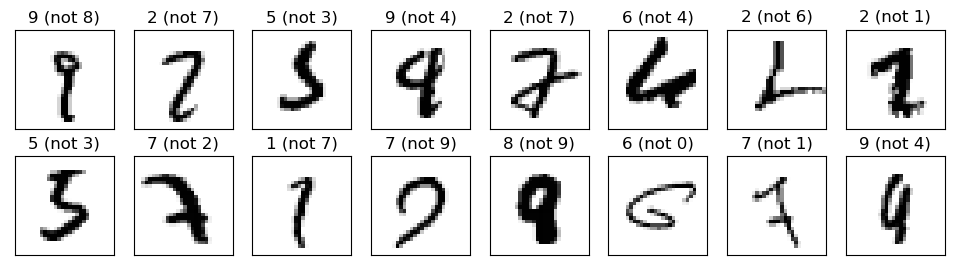

In [23]:
# test: 99.1% corresponds to about 50-100 wrong out of 60000 

wrong = np.where(model99(test_data.data[:,None].float()).argmax(1) != y_test)[0]
predicted = model99(test_data.data[wrong[:16],None].float()).argmax(1)

plt.figure(figsize=(12,3))
for k,i in enumerate(wrong[:16]):
    plt.subplot(2,8,k+1)
    plt.imshow(test_data.data[i], cmap='binary')
    plt.xticks([]), plt.yticks([])
    plt.title(f'{test_data.targets[i].item()} (not {predicted[k]})')

here are the 32 filters trained in the first convolutional layer

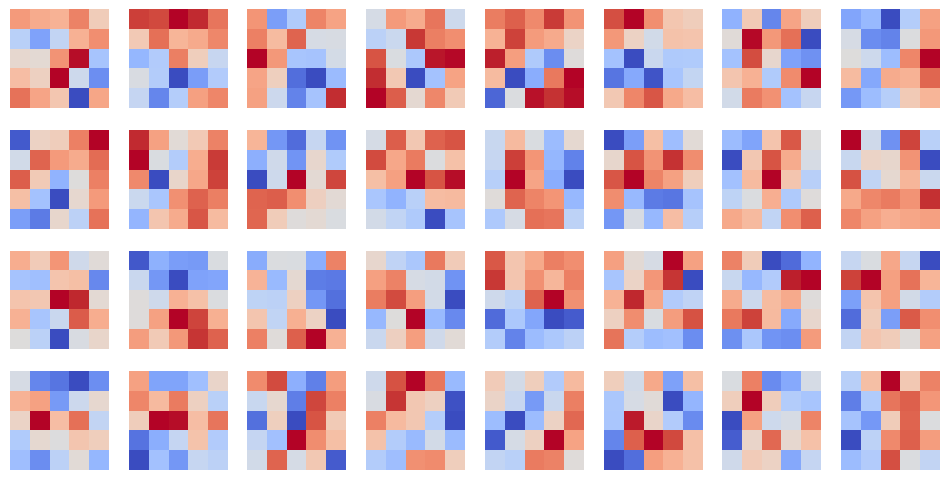

In [24]:
plt.figure(figsize=(12,6))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(list(model99.parameters())[0][i][0].detach().numpy(), cmap='coolwarm')
    plt.axis('off')

In [ ]:
list(model99.parameters())[2][i][0]

here are the 64 filters trained in the second convultional layer

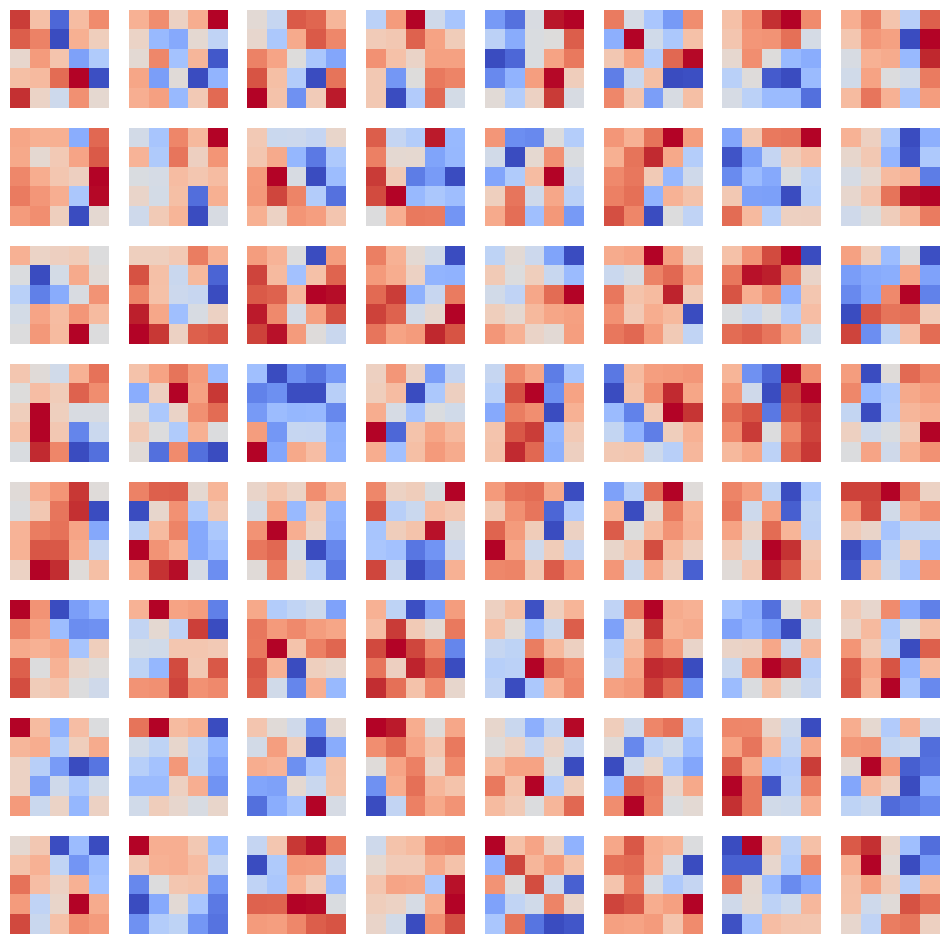

In [25]:
plt.figure(figsize=(12,12))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(list(model99.parameters())[2][i][2].detach().numpy(), cmap='coolwarm')
    plt.axis('off')

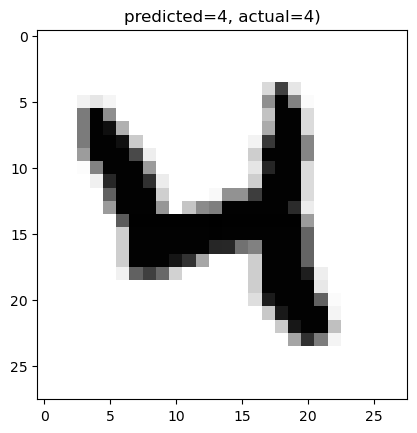

In [26]:
i = 20 #20->4, 23->1, 244->5
plt.imshow(train_data.data[i], cmap='binary');
pred = model99(train_data.data[None,i:i+1].float()).argmax().item()
actual = train_data.targets[i]
plt.title(f'predicted={pred}, actual={actual})');

In [27]:
model99

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=10, bias=True)
)

look at first two layers

In [28]:
layer0_output = model99[0](train_data.data[None,i:i+1].float()) #CNN layer
layer1_output = model99[1](layer0_output)   # ReLU
layer0_output.shape, layer1_output.shape  #ReLU doesn't change shape

(torch.Size([1, 32, 24, 24]), torch.Size([1, 32, 24, 24]))

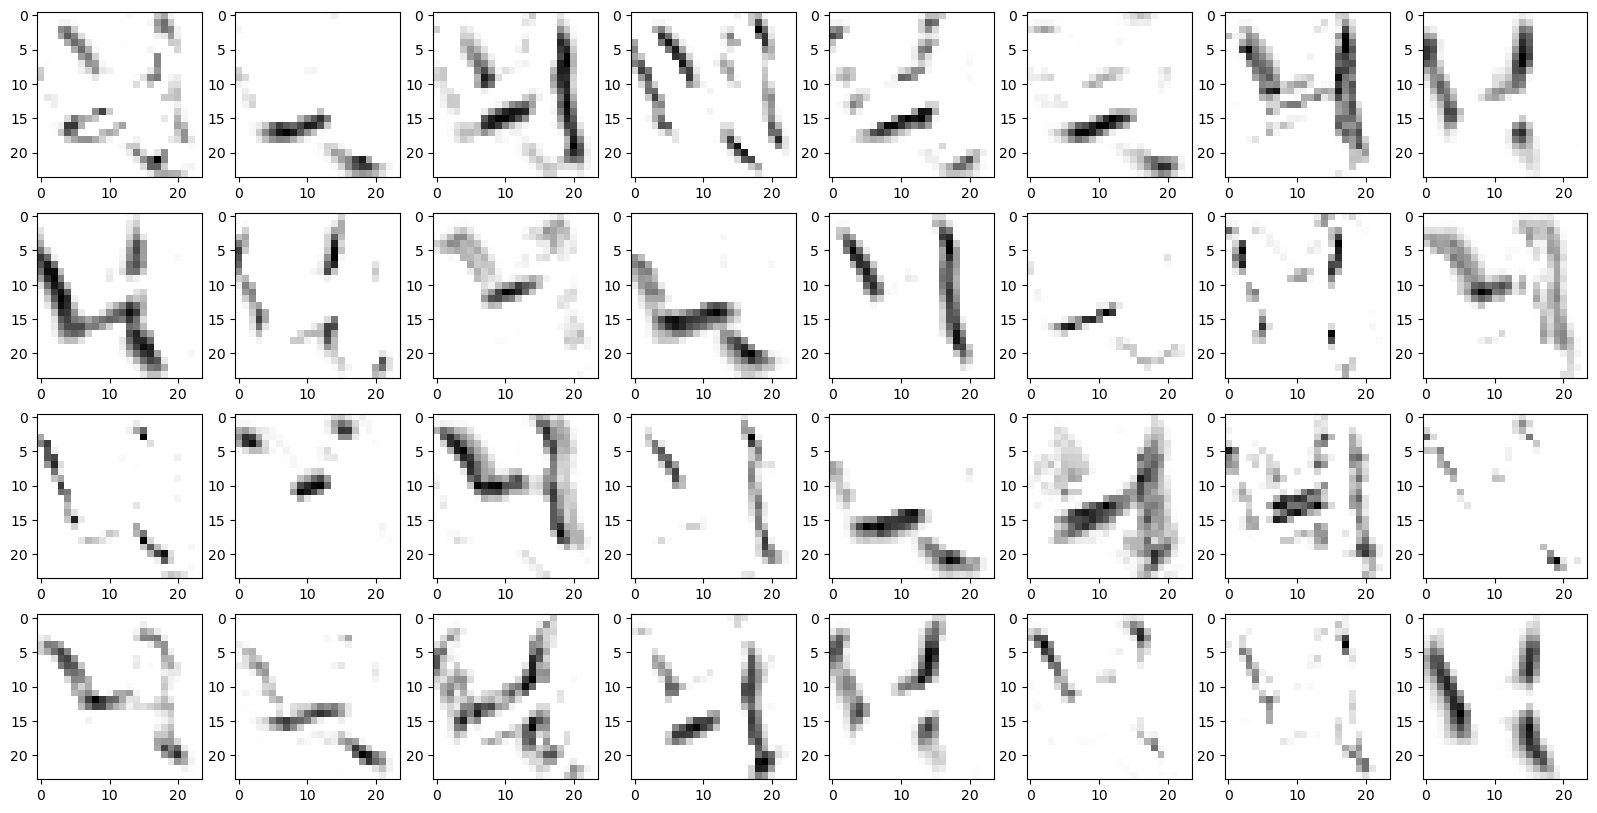

In [29]:
#output of first 5x5 conv layer and relu
plt.figure(figsize=(20,10))
for k in range(32):
   plt.subplot(4,8,k+1)
   plt.imshow(layer1_output[0,k].detach().numpy(), cmap='binary')

In [30]:
layer2_output = model99[2](layer1_output) #maxpool cuts size from 24x24 to 12x12 for each filter
layer2_output.shape

torch.Size([1, 32, 12, 12])

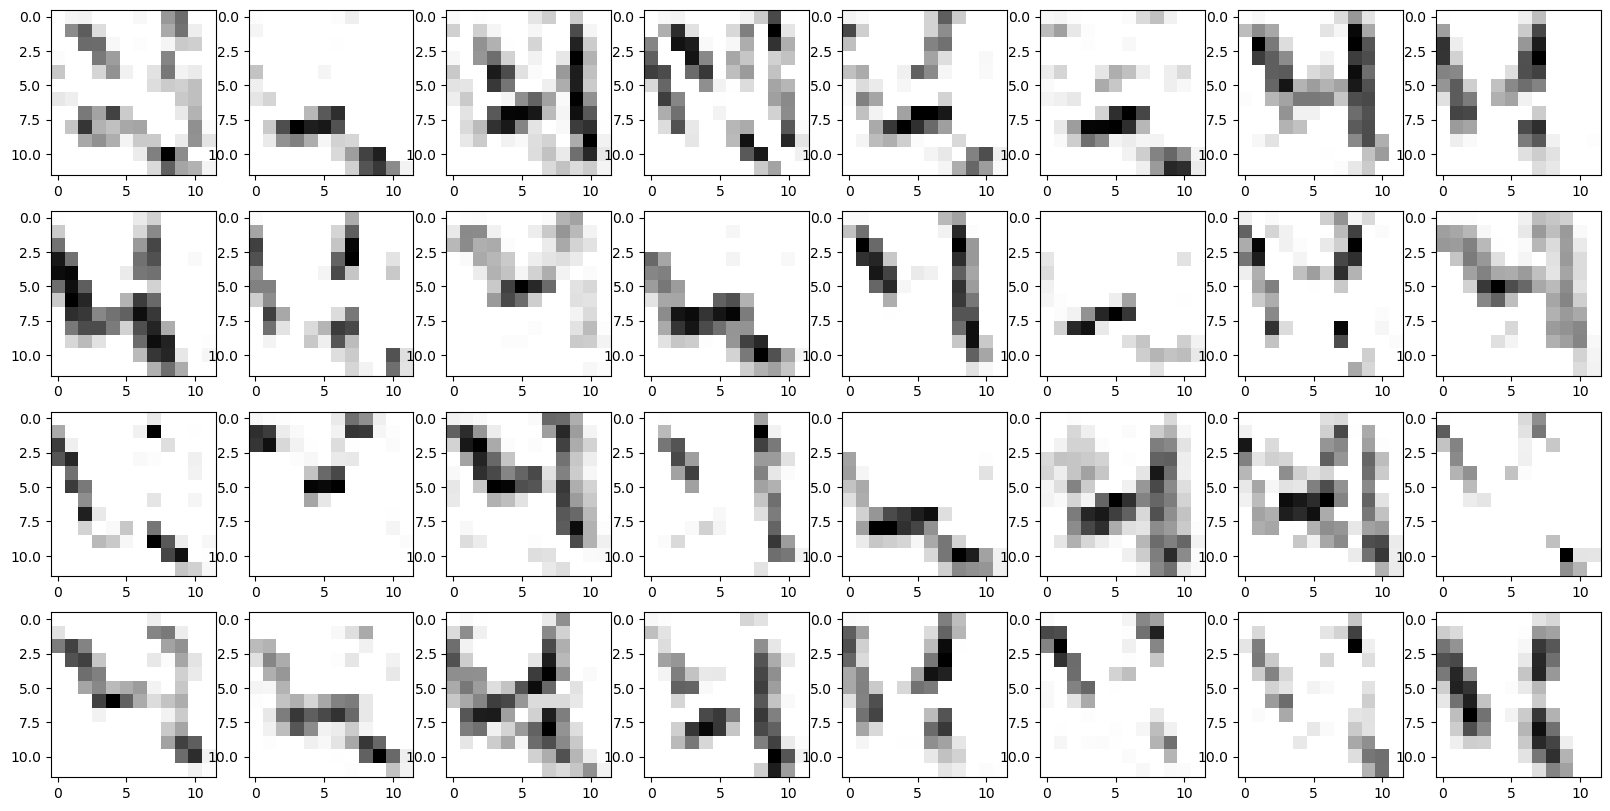

In [31]:
#12x12 output of first maxpool layer
plt.figure(figsize=(20,10))
for k in range(32):
   plt.subplot(4,8,k+1)
   plt.imshow(layer2_output[0,k].detach().numpy(), cmap='binary')

In [32]:
layer3_output = model99[3](layer2_output) # returns 64 5x5 filters
layer4_output = model99[4](layer3_output) #ReLU
layer4_output.shape

torch.Size([1, 64, 8, 8])

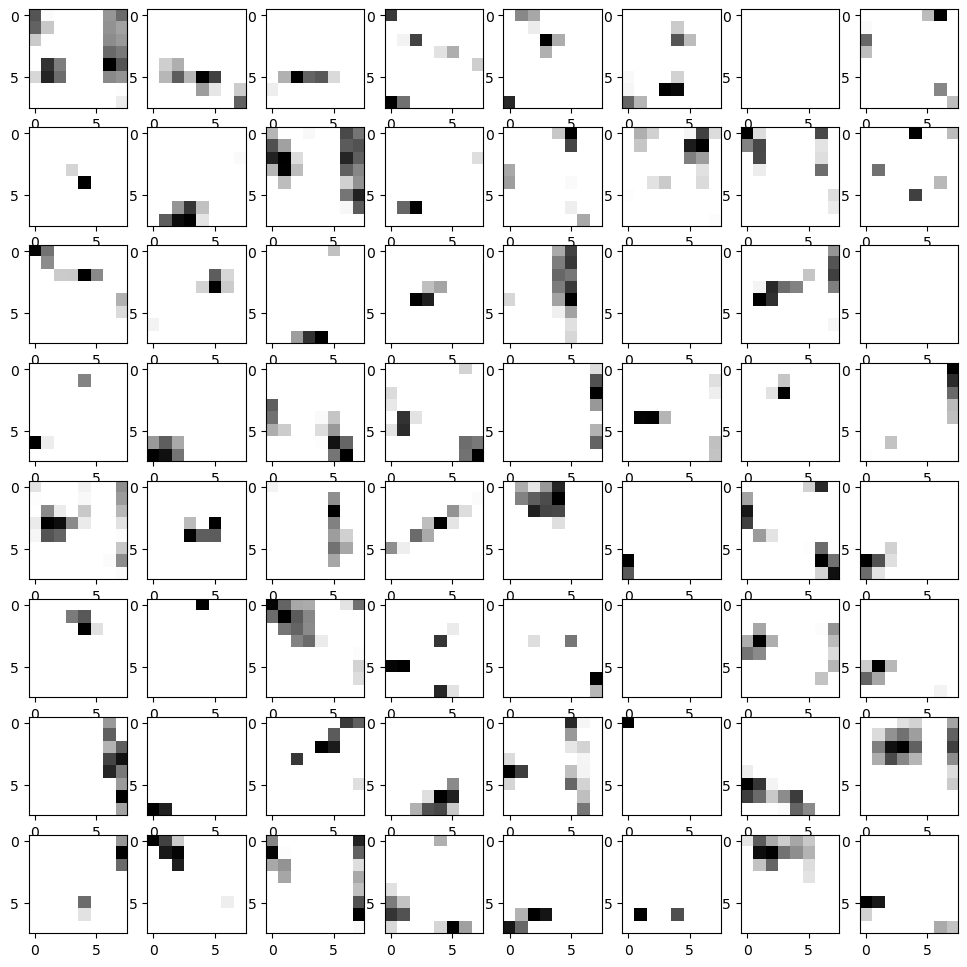

In [33]:
#output of second 5x5 conv layer and its ReLU
plt.figure(figsize=(12,12))
for k in range(64):
   plt.subplot(8,8,k+1)
   plt.imshow(layer4_output[0,k].detach().numpy(), cmap='binary')

In [34]:
layer5_output = model99[5](layer4_output) #maxpool cuts from 8x8 to 4x4 
layer5_output.shape

torch.Size([1, 64, 4, 4])

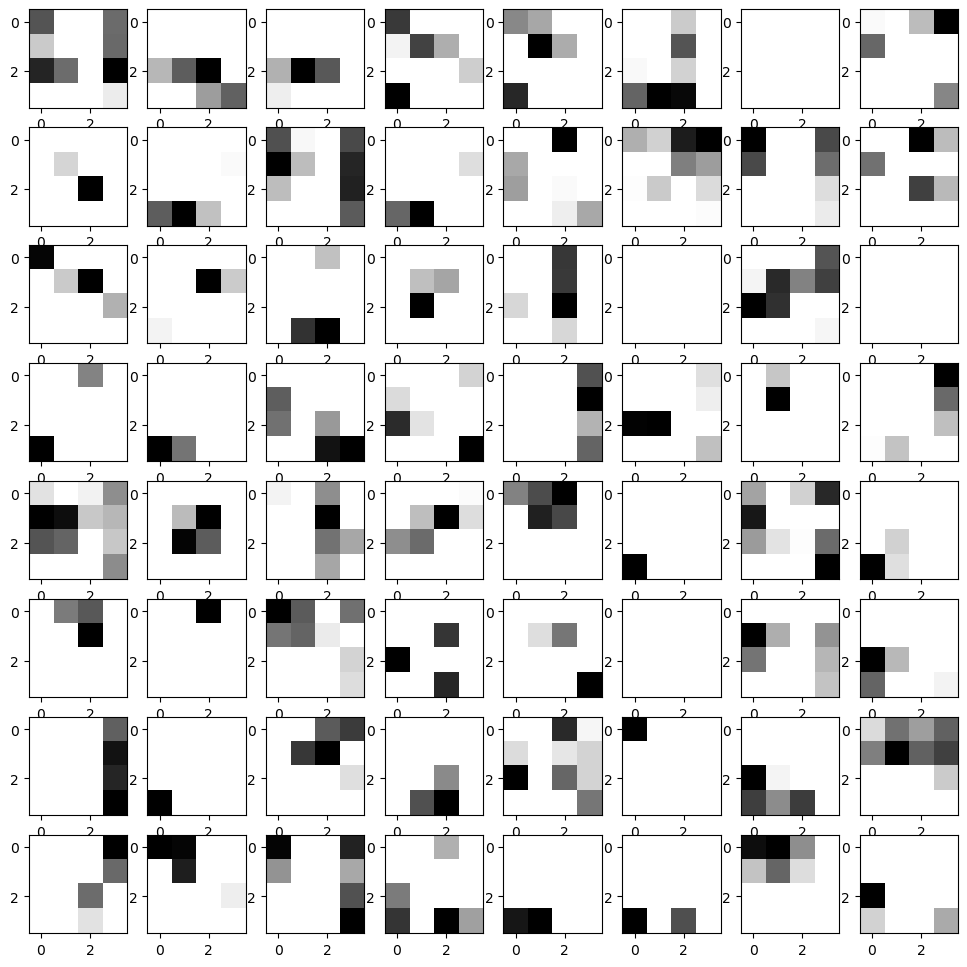

In [35]:
#4x4 output of 2nd layer maxpool layer
plt.figure(figsize=(12,12))
for k in range(64):
   plt.subplot(8,8,k+1)
   plt.imshow(layer5_output[0,k].detach().numpy(), cmap='binary')

final layer output prediction for digit

In [36]:
layer6_output = model99[6](layer5_output) #flatten
layer7_output = model99[7](layer6_output) #1024 -> 10
layer7_output.shape

torch.Size([1, 10])

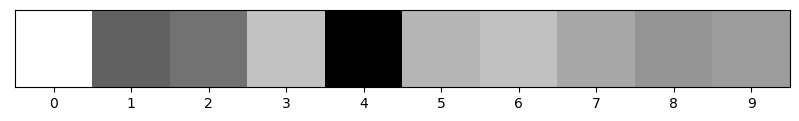

In [37]:
#output of last layer
plt.figure(figsize=(10,4))
plt.imshow(layer7_output.detach().numpy(), cmap='binary')
plt.xticks(range(10)), plt.yticks([]);

See [lec25_mnist_cifar10.ipynb](https://nbviewer.org/url/courses.cit.cornell.edu/info3950_2023sp/lec25_mnist_cifar10.ipynb)
for the continuation:

# IV. 99.5% MNIST model
...

# V. CIFAR10 model
...